In [52]:
from sklearn import datasets
import numpy as np

In [53]:
iris = datasets.load_iris()

X = iris.data[:,[2,3]]
y = iris.target

"""
np.unique(y) function returned the three unique class labels stored
in iris.target and as we see, the Iris flower class names Iris-setosa, 
Iris-versicolor, and Iris-virginica are already stored as integers (here: 0, 1, 2)

Integer labels is recommended to avoid technical glitches and improve computational
due to a smaller memory footprint. Also is a common convention among most ML library

"""
print('Class labels:',np.unique(y))

Class labels: [0 1 2]


In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=1,stratify = y)

In [55]:
"""
Stratify returns training and test subsets that have the same proportions
of the class labels as the input dataset
"""
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))


Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [56]:
"""
feature scaling for optimal performance
"""

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train) #estimate the sample mean and standard errors
X_train_std=sc.transform(X_train) #standardize the training data using those estimated parameters
X_test_std=sc.transform(X_test)



In [57]:
#Training a perceptron via scikit-learn

from sklearn.linear_model import Perceptron

ppn = Perceptron(n_iter = 40, eta0 = 0.1, random_state=1)

ppn.fit(X_train_std,y_train)

/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Perceptron(alpha=0.0001, class_weight=None, eta0=0.1, fit_intercept=True,
      max_iter=None, n_iter=40, n_jobs=1, penalty=None, random_state=1,
      shuffle=True, tol=None, verbose=0, warm_start=False)

In [58]:
y_pred = ppn.predict(X_test_std)

print('Misclassfied samples: %d' %(y_test != y_pred).sum())

Misclassfied samples: 3


In [59]:
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' %accuracy_score(y_test,y_pred)) #Compare True and Predicted label
print('Accuracy: %.2f' %ppn.score(X_test_std,y_test)) #Each classifier in scikit-learn has a score method

Accuracy: 0.93
Accuracy: 0.93


In [60]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    #setup market generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    #plot the decision surface
    
    x1_min, x1_max = X[:,0].min()-1,X[:,0].max()+1
    x2_min, x2_max = X[:,1].min()-1,X[:,1].max()+1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1,xx2,Z,alpha=0.3,cmap=cmap)
    
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0],
                   y=X[y==cl,1],
                   alpha = 0.8,
                   c=colors[idx],
                   marker=markers[idx],
                   label=cl,
                   edgecolor='black')
        
    #hightlight test samples
    if test_idx:
        #plot all samples
        X_test, y_test = X[test_idx,:], y[test_idx]
        
        plt.scatter(X_test[:,0],
                   X_test[:,1],
                   c='',
                   edgecolor="black",
                   alpha=1.0,
                   linewidth=1,
                   marker='o',
                   s=100,
                   label = 'test set')
    

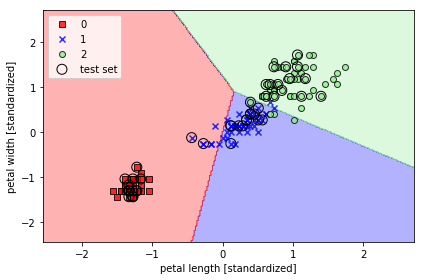

In [61]:
#Training a perceptron model using the standardized training data:
X_combined_std=np.vstack((X_train_std,X_test_std))
y_combined = np.hstack((y_train,y_test))

plot_decision_regions(X=X_combined_std,y=y_combined,
                     classifier=ppn,test_idx=range(105,150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
plt.legend(loc='upper left')
plt.tight_layout()

plt.show()

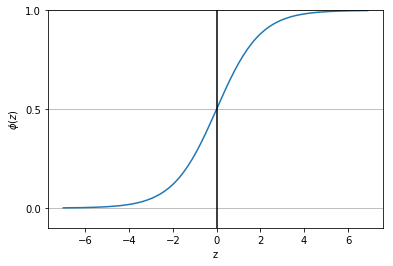

In [62]:
#Modeling class probabilities via logistic regression

#Logistic regression intuition and conditional probabilities


def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

z = np.arange(-7,7,0.1)
phi_z = sigmoid(z)

plt.plot(z,phi_z)
plt.axvline(0.0,color='k')
plt.ylim(-0.1,1,1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

#y axis ticks 
plt.yticks([0.0,0.5,1.0])
#y grid line
ax = plt.gca()
ax.yaxis.grid(True)
plt.show()



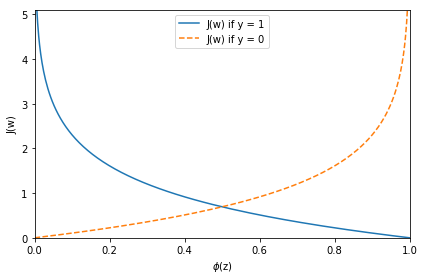

In [63]:
#Learning the weights of the logistic cost function

def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1-sigmoid(z))

z = np.arange(-10,10,0.1)

phi_z = sigmoid(z)

cl = [cost_1(x) for x in z]
plt.plot(phi_z,cl,label='J(w) if y = 1')

c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle = '--',label='J(w) if y = 0')

plt.ylim(0.0,5.1)
plt.xlim([0,1])
plt.xlabel("$\phi$(z)")
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()

plt.show()


In [64]:
class LogisticRegrssionGD(object):
    """Logistic Regression Classifier using gradient descent
    
    Parameters
    ------------------
    eta: float
        Learning rate (between 0.0 and 0.1)
    n_iter:
        Passes over the training dataset
    random_state: int
        Random number generator seed for random weight
        initialization
    
    Attributes
    ------------------
    w_: 1d-array
        Weights after fitting
    cost_: list
        Logistic cost function value in each epoch
    
    """
    
    def __init__(self,eta=0.05,n_iter=100,random_state=1):
        self.eta=eta
        self.n_iter = n_iter
        self.random_state=random_state
        
    def fit(self,X,y):
        """Fit training data
        
        Parameteres
        -----------------------
        X: {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features
        y: array-like, shape=[n_sample]
            Target values.
            
        Returns
        ---------
        self: object
        
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0,scale=0.01,size = 1+X.shape[1])
        self.cost_=[]
        
        for i in range(self.n_iter):
            net_input=self.net_input(X)
            output=self.activation(net_input)
            errors=(y-output)
            self.w_[1:]+=self.eta*X.T.dot(errors)
            self.w_[0]+=self.eta*errors.sum()
            
            #note that we compute the logistic 'cost' now
            #instead of the sum of the squared errors cost
            cost = -y.dot(np.log(output))-((1-y).dot(np.log(1-output)))
            self.cost_.append(cost)
        return self
    def net_input(self,X):
        """Calculate net input"""
        return np.dot(X,self.w_[1:])+self.w_[0]
    
    def activation(self,z):
        """Compute logistic sigmoid activation"""
        #clip sets the floor and the ceiling of the z
        return 1.0/(1.0+np.exp(-np.clip(z,-250,250)))
    
    def predict(self,X):
        """Return class label after unit step"""
        return np.where(self.net_input(X)>=0.0,1,0)
    #equivalent to:
    #return np.where(self.activation(self.net_input(X))>=0.5,1,0)



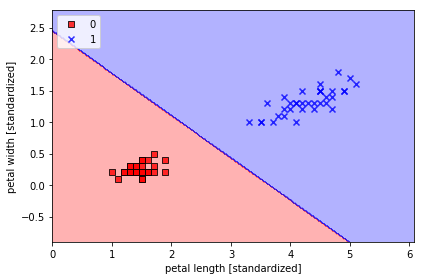

In [65]:
X_train_01_subset = X_train[(y_train==0)|(y_train==1)]
y_train_01_subset = y_train[(y_train==0)|(y_train==1)]

lrgd = LogisticRegrssionGD(eta=0.05,
                           n_iter=1000,
                           random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()

plt.show()




/home/Rex/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:641: UserWarning: Unrecognized location "upper". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


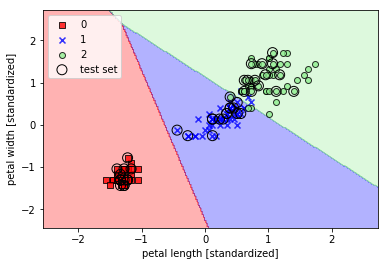

In [66]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0,random_state=1)
lr.fit(X_train_std,y_train)
plot_decision_regions(X_combinded_std,
                     y_combined,
                     classifier=lr,
                     test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper')
plt.show()

In [67]:
lr.predict_proba(X_test_std[:3,:])

array([[3.20136878e-08, 1.46953648e-01, 8.53046320e-01],
       [8.34428069e-01, 1.65571931e-01, 4.57896429e-12],
       [8.49182775e-01, 1.50817225e-01, 4.65678779e-13]])

In [68]:
lr.predict_proba(X_test_std[:3,:]).sum(axis=1)

array([1., 1., 1.])

In [69]:
lr.predict_proba(X_test_std[:3,:]).argmax(axis=1)

array([2, 0, 0])

In [70]:
lr.predict(X_test_std[:3,:])

array([2, 0, 0])

In [71]:
"""
a word of caution
if you want to predict the class label of a single flower sample,
sciki-learn expects a two-dimentional array as data input
we have to convert a single row slice into such a format first
one way is to use reshape function
"""

lr.predict(X_test_std[0,:].reshape(1,-1))


array([2])

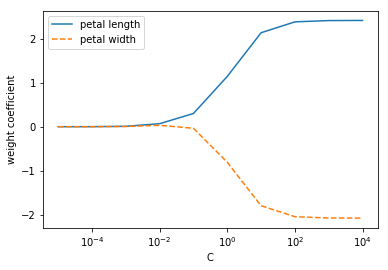

In [72]:
weights, params = [],[]
for c in np.arange(-5,5):
    lr = LogisticRegression(C=10.0**c,random_state=1)
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10.0**c)
    
weights = np.array(weights)
plt.plot(params,weights[:,0],
        label='petal length')
plt.plot(params,weights[:,1],linestyle='--',
        label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()



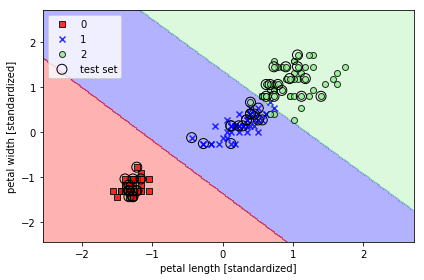

In [73]:
#Support vector machine

from sklearn.svm import SVC

svm=SVC(kernel='linear',C=1.0,random_state=1) 
#C control the penalty for misclassiciation
#large C, large penalty, large variance
svm.fit(X_train_std,y_train)

plot_decision_regions(X_combinded_std,
                     y_combined,
                     classifier=svm,
                     test_idx=range(105,150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()


plt.show()

In [74]:
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron', n_iter=1000)
lr = SGDClassifier(loss='log', n_iter=1000)
svm = SGDClassifier(loss='hinge', n_iter=1000)

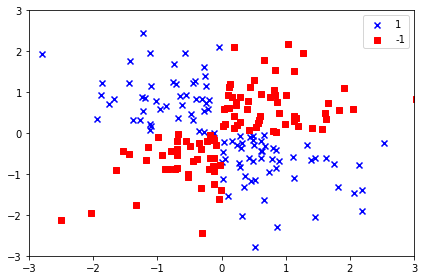

In [75]:
#Solving non-linear problems using a kernel SVM

np.random.seed(1)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0]>0,
                      X_xor[:,1]>0)
y_xor = np.where(y_xor,1,-1)

plt.scatter(X_xor[y_xor==1,0],
           X_xor[y_xor==1,1],
           c='b',marker='x',label='1')

plt.scatter(X_xor[y_xor==-1,0],
           X_xor[y_xor==-1,1],
           c='r',marker='s',label='-1')

plt.xlim([-3,3])

plt.ylim([-3,3])
plt.legend(loc='best')
plt.tight_layout()

plt.show()



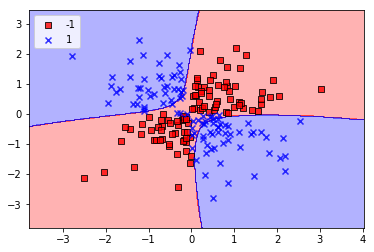

In [76]:
#Using the kernel trick to find separating hyperplanes in higher dimensional space

#replace kernel = 'linear' parameter with kernel = 'rbf'

svm = SVC(kernel='rbf',random_state=1,gamma=0.1,C=10.0)
svm.fit(X_xor,y_xor)
plot_decision_regions(X_xor,y_xor,classifier=svm)
plt.legend(loc='upper left')
plt.show()

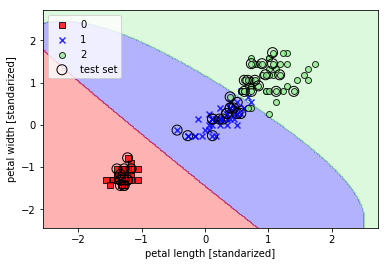

In [77]:
#increase the value for gamma, increase the influence or reach
#of the training samples, leads to a tighter and bumpier decision boundary

svm = SVC(kernel='rbf',random_state=1,gamma=0.2,C=1.0)
svm.fit(X_train_std,y_train)

plot_decision_regions(X_combinded_std,
                     y_combined,classifier=svm,
                     test_idx=range(105,150))

plt.xlabel('petal length [standarized]')
plt.ylabel('petal width [standarized]')
plt.legend(loc='upper left')

plt.show()



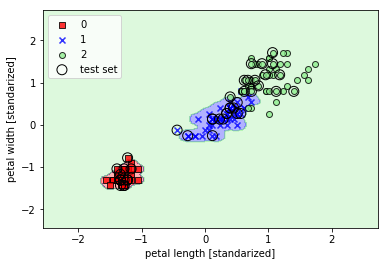

In [78]:
svm = SVC(kernel='rbf',random_state=1,gamma=100,C=1.0)
svm.fit(X_train_std,y_train)

plot_decision_regions(X_combinded_std,
                     y_combined,classifier=svm,
                     test_idx=range(105,150))

plt.xlabel('petal length [standarized]')
plt.ylabel('petal width [standarized]')
plt.legend(loc='upper left')

plt.show()

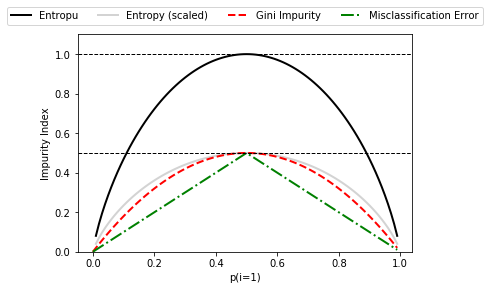

In [86]:
#Decision Tree learning
#Maximizing informaton gain - getting the most bang for the buck

def gini(p):
    return p*(1-p)+(1-p)*(1-(1-p))

def entropy(p):
    return -p*np.log2(p)-(1-p)*np.log2((1-p))

def error(p):
    return 1 - np.max([p,1-p])


x = np.arange(0.0,1.0,0.01)

ent = [entropy(p) if p != 0 else None for p in x]

sc_ent = [e*0.5 if e else None for e in ent] #scale the entropy

err = [error(i) for i in x]

#fig = plt.figure()
ax = plt.subplot(111)

for i, lab, ls, c, in zip([ent,sc_ent,gini(x),err],
                          ['Entropu','Entropy (scaled)',
                           'Gini Impurity', 'Misclassification Error'],
                          ['-','-','--','-.'],
                          ['black','lightgray','red','green','cyan']):
    line = ax.plot(x,i,label=lab,linestyle=ls,lw=2,color=c)

ax.legend(loc="upper center",bbox_to_anchor=(0.5,1.15),
         ncol=5,fancybox=True,shadow=False)


ax.axhline(y=0.5,linewidth=1,color='k',linestyle='--')
ax.axhline(y=1.0,linewidth=1,color='k',linestyle='--')

plt.ylim([0,1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')

plt.show()



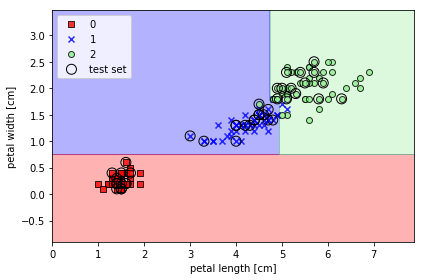

In [88]:
#Building a decision tree

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini',
                             max_depth=4,
                             random_state=1)
tree.fit(X_train,y_train)

X_combined = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))
plot_decision_regions(X_combined,y_combined,
                      classifier=tree,test_idx=range(105,150))


plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()


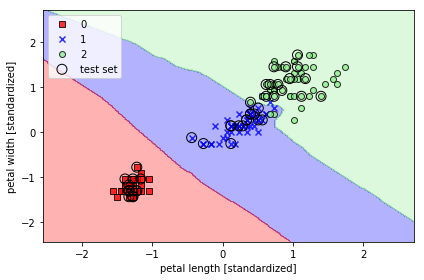

In [80]:
#K-nearest neighbors - a lazy learning algorithm

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
knn.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

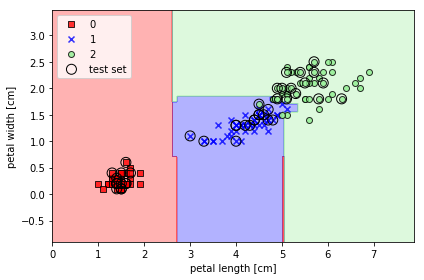

In [90]:
##Combining weak to strong learners via random forests

from sklearn.ensemble import RandomForestClassifier

#the size of the bootstrap sample is chosen to be equal to the number of samples in the original training set
#for the number of features d at each split, default is d = sqrt(m), m is the number of features in the training set

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=25,
                                random_state=1,
                                n_jobs = 2)


forest.fit(X_train, y_train)


plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.show()

